[View in Colaboratory](https://colab.research.google.com/github/delkind/paraphraser/blob/master/notebooks/paraphraser_num2word.ipynb)

In [1]:
# SETUP

%load_ext autoreload
%autoreload 2


# colab requirements
#!pip install spacy  #only for bible
!pip install pydrive   #to save to google-drive
!pip install num2words #only for numbers

import tensorflow as tf
import sys
import numpy as np


# our github proj
!rm -r paraphraser  #remove previous github copy if needed
!git clone https://github.com/delkind/paraphraser.git
sys.path.append('paraphraser/src')

from utils.persistency import Persistency    #your code here!!!
from models import D_G_Model



    100% |████████████████████████████████| 993kB 7.2MB/s 
  Running setup.py bdist_wheel for pydrive ... - \ done
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive
    100% |████████████████████████████████| 102kB 3.3MB/s 
  Running setup.py bdist_wheel for num2words ... - \ done
  Stored in directory: /root/.cache/pip/wheels/e5/f6/a1/78cb080e8529bfa0c6ee2461563a4ff96efc0b6fe89cb31457
Successfully built num2words


# Dataset

In [0]:
from dataset.num2word import Num2WordsDataset
dataset = Num2WordsDataset(start=1, end=1*1000,use_num_names=True)#10*1000*1000) 



In [0]:
# example for datasets generators
def show_dataset_example():
  (x1,x2),y1=next(dataset.gen_g(dataset.train, batch_size=3))
  for b in range(len(x1)):
    print ('x1',x1.shape,dataset.recostruct_sentence(x1[b]))
    print ('x2',x2.shape,dataset.recostruct_sentence(x2[b]))
    print ('y1',y1.shape,dataset.recostruct_sentence(y1[b].argmax(axis=1)))
    print ('')  
  print ('results of gen_adv')  
  (x1, x2), (y1,y2) = next(dataset.gen_adv(dataset.train, batch_size=3, noise_std=0.5))  
  for b in range(len(x1)):
    print ('x1',x1.shape,dataset.recostruct_sentence(x1[b]))
    print ('x2',x2.shape,dataset.recostruct_sentence(x2[b]))
    print ('y1',y1.shape,dataset.recostruct_sentence(y1[b].argmax(axis=1)))
    print ('y2',y2[b])


#show_dataset_example()  #unmark it to understand how the data looks


# Create Model 

In [26]:
from models import D_G_Model,D_G_Trainer
from decoder import SamplingDecoder


model = D_G_Model(num_encoder_tokens=len(dataset.word2index),
                      num_decoder_tokens=len(dataset.word2index),  #from dataset 3628
                      style_out_size=len(dataset.style2index), #from dataset 2
                      cuddlstm=True,
                      latent_dim = 10, #twice the default. make it stronger! but slower
                      bidi_encoder = True,
                      adv_loss_weight=100,) #500
model.build_all()

sampler= SamplingDecoder(model)   # decoder by sampling   

trainer = D_G_Trainer(model,dataset)  # trainer has utilties to fit and eval on various models



unoptimzied decode_sequence_batch, running each of the N sample seperatly
unoptimzied decode_sequence_batch, running each of the N sample seperatly
epoc is of 21 of batches 64 total train_size 1404


# cycle appraoch

Epoch 1/1
20/20 [==============================] - 1s 40ms/step - loss: 0.6963 - acc: 0.4812 - val_loss: 0.7490 - val_acc: 0.0625
Epoch 1/1
20/20 [==============================] - 2s 88ms/step - loss: 0.1535 - dcd_sfmax_loss: 0.0611 - styl_clsf_loss: 9.2332e-04 - val_loss: 6.4947 - val_dcd_sfmax_loss: 6.2698 - val_styl_clsf_loss: 0.0022
Epoch 1/1
20/20 [==============================] - 2s 124ms/step - loss: 0.2395 - dcd_sfmax_loss: 0.1524 - styl_clsf_loss: 8.7142e-04 - val_loss: 7.1582 - val_dcd_sfmax_loss: 7.1468 - val_styl_clsf_loss: 1.1395e-04


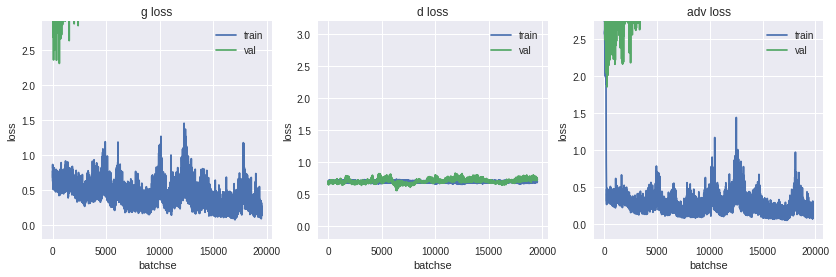

############################## verb 10 ##############################

##encoder_input[<num>]: two zero nine
decoder TF     [<num>]: two zero nine <end> <end> <end>
gold label     [<num>]: two zero nine
decoder TF     [<wrd>]: two hundred and thirteen <end> <end>
gold label     [<wrd>]: two hundred and nine

##encoder_input[<wrd>]: two hundred and nine
decoder TF     [<num>]: two nine nine <end> <end> <end>
gold label     [<num>]: two zero nine
decoder TF     [<wrd>]: two hundred and nine <end> <end>
gold label     [<wrd>]: two hundred and nine
############################## verb 25 ##############################

##encoder_input[<num>]: two two four
decoder TF     [<num>]: two two four <end> <end> <end>
gold label     [<num>]: two two four
decoder TF     [<wrd>]: two hundred and fifty two <end>
gold label     [<wrd>]: two hundred and twenty four

##encoder_input[<wrd>]: two hundred and twenty four
decoder TF     [<num>]: two three three <end> <end> <end>
gold label     [<num>]: two tw

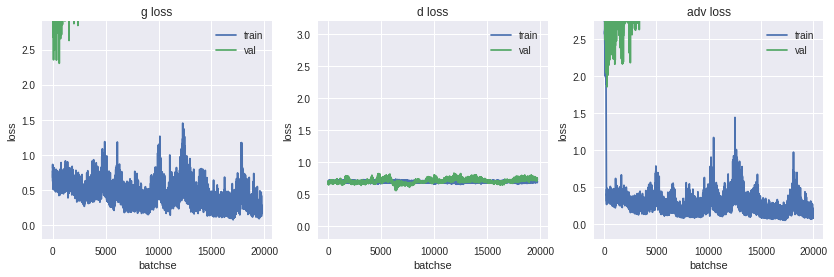

############################## verb 10 ##############################

##encoder_input[<num>]: two zero nine
decoder TF     [<num>]: two zero nine <end> <end> <end>
gold label     [<num>]: two zero nine
decoder TF     [<wrd>]: two hundred and thirteen <end> <end>
gold label     [<wrd>]: two hundred and nine

##encoder_input[<wrd>]: two hundred and nine
decoder TF     [<num>]: two nine nine <end> <end> <end>
gold label     [<num>]: two zero nine
decoder TF     [<wrd>]: two hundred and nine <end> <end>
gold label     [<wrd>]: two hundred and nine
############################## verb 25 ##############################

##encoder_input[<num>]: two two four
decoder TF     [<num>]: two two four <end> <end> <end>
gold label     [<num>]: two two four
decoder TF     [<wrd>]: two hundred and fifty two <end>
gold label     [<wrd>]: two hundred and twenty four

##encoder_input[<wrd>]: two hundred and twenty four
decoder TF     [<num>]: two three three <end> <end> <end>
gold label     [<num>]: two tw

In [40]:
for outside_epoc in range(2):
  steps_d,steps_g=(20,20) #use 20 steps for verbosity
  for inside_epoc in range(200):
      #trainer.train_g(steps_d,batch_size=32,noise_std=1.0)
      trainer.train_d(steps_d,batch_size=32,noise=0.05)
      trainer.train_d_g(steps_g ,batch_size=32,noise=0.0,noise_std=3.0)
      trainer.train_g_cycle(steps_g,batch_size=32,noise_std=0.0)
      steps_d,steps_g= (1,1)
  trainer.plt_all()
  sampler.show_sample(dataset,'train'  ,sample_ids=[10,25],teacher_forcing=True)   #,8000+0


# FAQ and wierd exceptions

* If you get exceptions related to cuda-lstm , inside the show_sample, but you actially not using it at all.  You will need to restart the notebook (thinking it's TF issue/bug)

* why the decoder shows bad sentences when my loss gets lower?  the loss should be **very** low before you start getting real results. typically values of g of less than 0.5

* why unkown-style sentences always generate the same sentence? probably "mode collapse" encountred during adverserial-training

* why the sampler without teacher-forcing emits garabage? if it emits the 1st word differently from teacher-forcing, it means that the models somehow got disconnected, or that you use wrong label (y1 should be one-hot of x1 not of x2)